In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lstm_policy import pad_and_concat
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [3]:
np.set_printoptions(precision=2, suppress=True)

In [4]:
import tensorflow as tf
import os

BATCH_SIZE = 64

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
META_FILE = "series/18-03-24-020248/var7/models/activepolicy-18-03-24-020450/model-6400000.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from series/18-03-24-020248/var7/models/activepolicy-18-03-24-020450/model-6400000


In [5]:
g_inputs = graph.get_tensor_by_name("inputs:0")
g_lengths = graph.get_tensor_by_name("lengths:0")

In [6]:
g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])

0.99999774 [1.    0.999 1.    1.    1.    0.997 1.    0.999 0.01  0.001 0.001 0.
 0.005 0.   ]


In [9]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")

class LSTMBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] * BATCH_SIZE
        cnfs_clauses = [[claus + tuple([claus[0]] * (3-len(claus))) for claus in cnf.clauses] for cnf in cnfs]
        inputs, lengths = pad_and_concat(cnfs_clauses)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs, g_lengths: lengths})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', cnfs_clauses[0], end=' ', file=logfile)
        print("probs:",  policy_probs[0], end=' \n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][(var-1)*2 + (0 if svar > 0 else 1)]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [10]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [11]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [12]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, LSTMBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

#Sats: 400; avg step: 3.63; stdev step: 1.20; avg error: 0.57; stdev error: 0.63


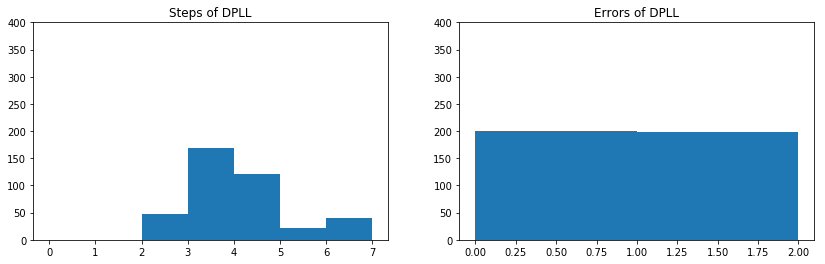

#Sats: 400; avg step: 3.71; stdev step: 1.17; avg error: 0.66; stdev error: 0.66


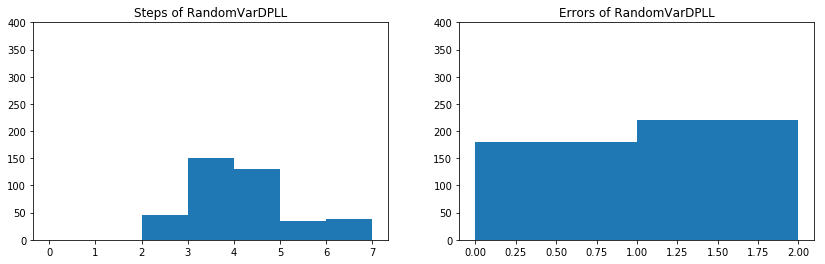

#Sats: 400; avg step: 2.99; stdev step: 0.80; avg error: 0.16; stdev error: 0.37


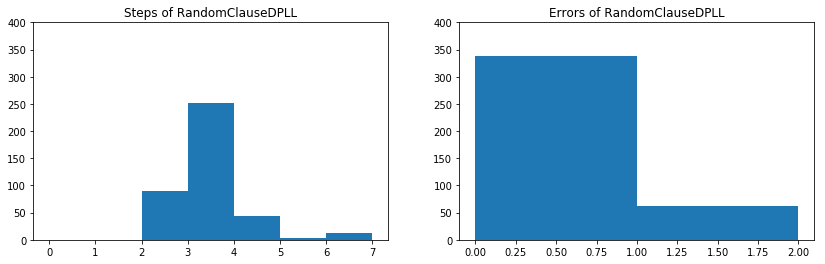

#Sats: 400; avg step: 2.92; stdev step: 0.61; avg error: 0.03; stdev error: 0.16


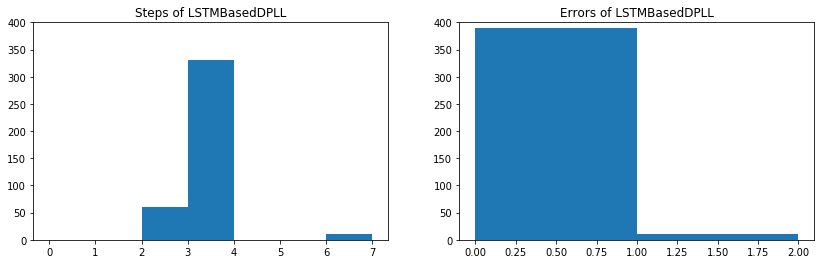

#Sats: 400; avg step: 2.64; stdev step: 0.50; avg error: 0.01; stdev error: 0.09


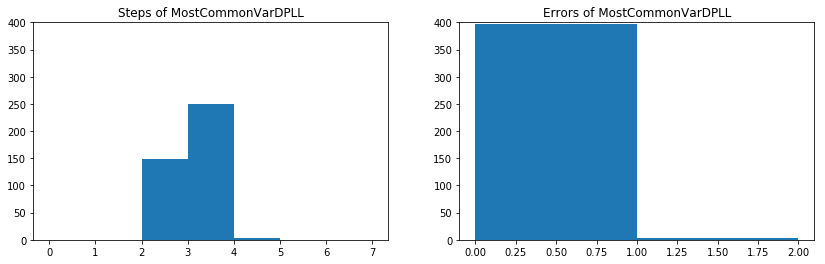

In [13]:
print_all(400, 2, 2, 3)

#Sats: 100; avg step: 8.62; stdev step: 2.87; avg error: 2.09; stdev error: 1.01


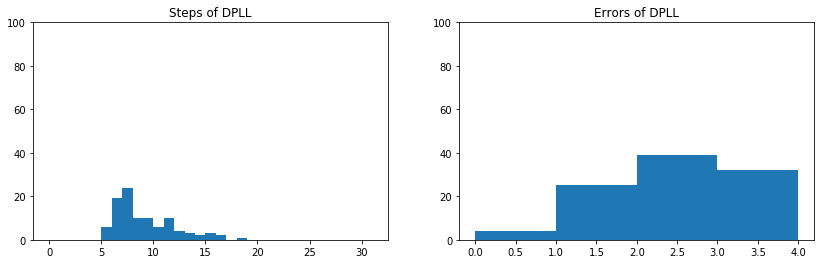

#Sats: 100; avg step: 8.28; stdev step: 2.40; avg error: 1.96; stdev error: 1.11


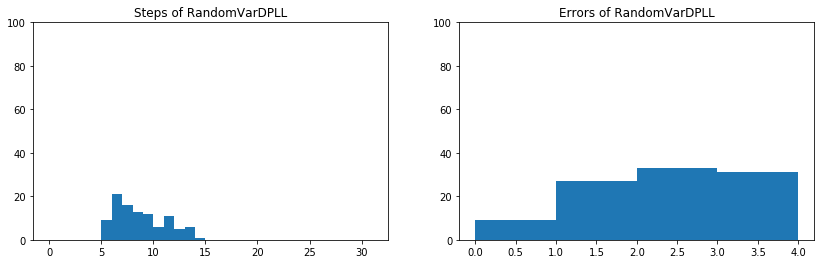

#Sats: 100; avg step: 7.20; stdev step: 2.65; avg error: 0.96; stdev error: 0.86


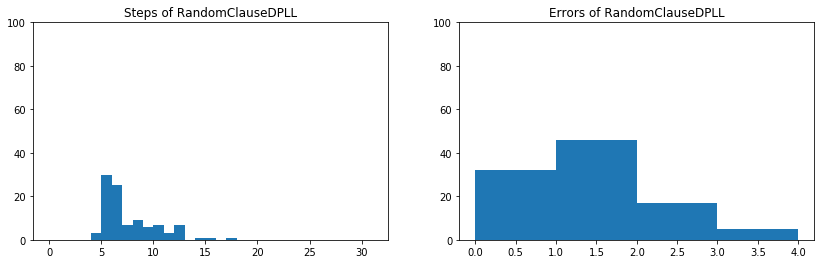

#Sats: 100; avg step: 5.10; stdev step: 1.00; avg error: 0.02; stdev error: 0.14


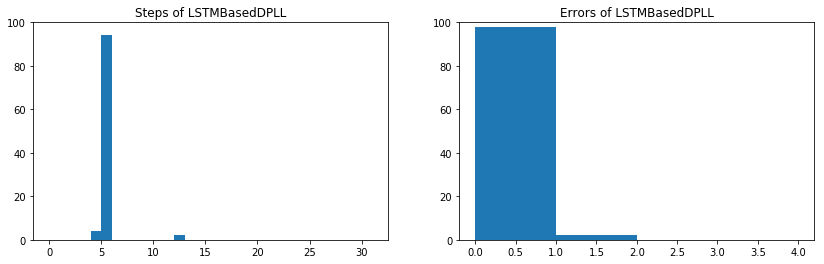

#Sats: 100; avg step: 5.14; stdev step: 0.80; avg error: 0.10; stdev error: 0.33


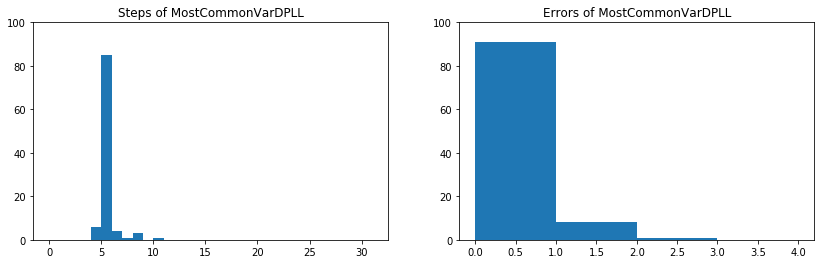

In [14]:
print_all(100, 2, 4, 20)

#Sats: 100; avg step: 7.38; stdev step: 3.47; avg error: 1.04; stdev error: 0.80


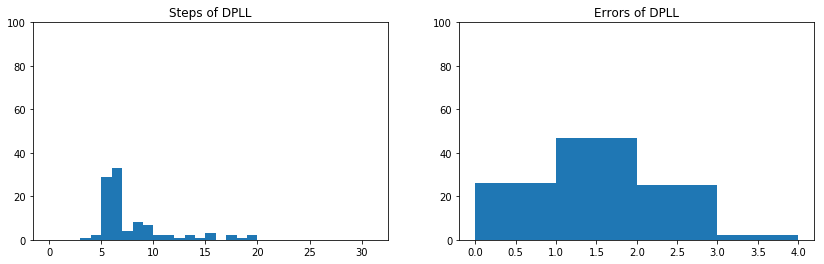

#Sats: 100; avg step: 8.19; stdev step: 4.13; avg error: 1.17; stdev error: 0.85


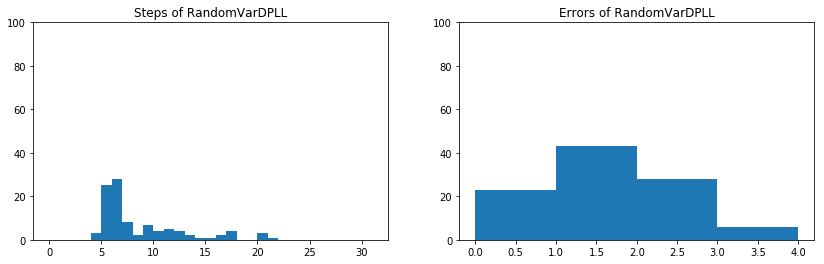

#Sats: 100; avg step: 5.77; stdev step: 2.49; avg error: 0.36; stdev error: 0.56


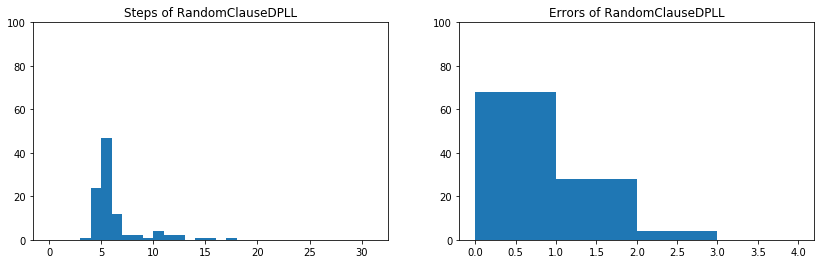

#Sats: 100; avg step: 4.75; stdev step: 1.45; avg error: 0.02; stdev error: 0.14


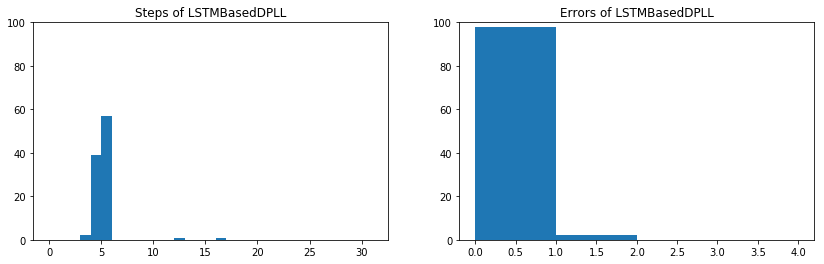

#Sats: 100; avg step: 4.42; stdev step: 1.22; avg error: 0.08; stdev error: 0.27


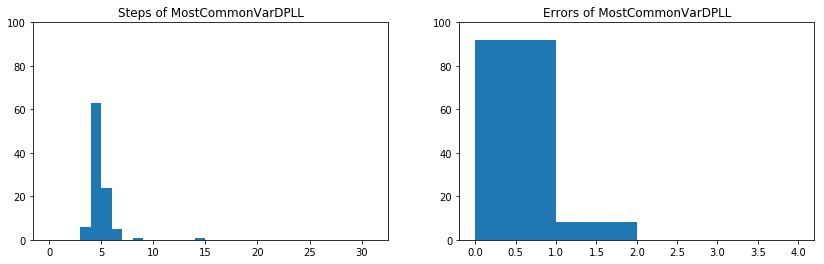

In [15]:
print_all(100, 3, 4, 10)

#Sats: 100; avg step: 10.09; stdev step: 4.68; avg error: 1.67; stdev error: 1.00


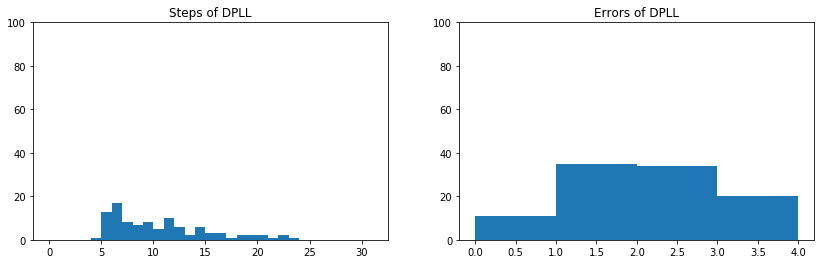

#Sats: 100; avg step: 9.27; stdev step: 4.43; avg error: 1.58; stdev error: 0.99


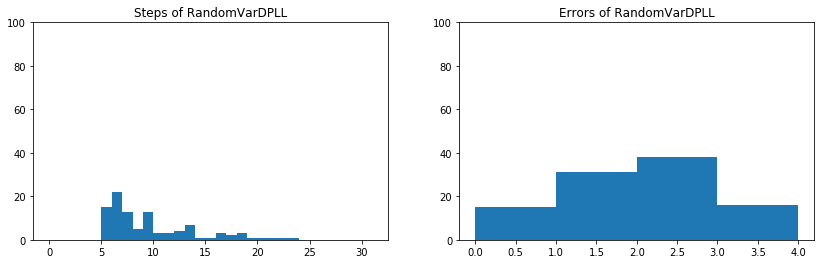

#Sats: 100; avg step: 8.49; stdev step: 4.26; avg error: 1.00; stdev error: 0.94


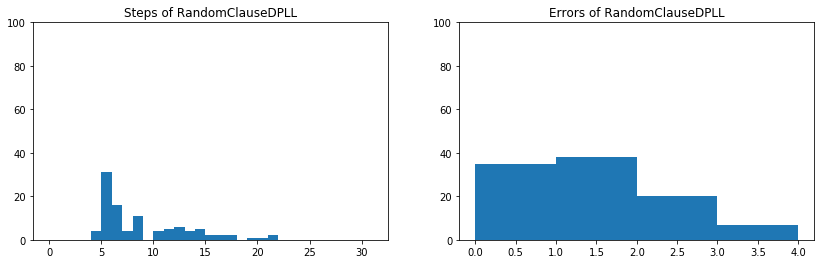

#Sats: 100; avg step: 5.71; stdev step: 2.68; avg error: 0.11; stdev error: 0.31


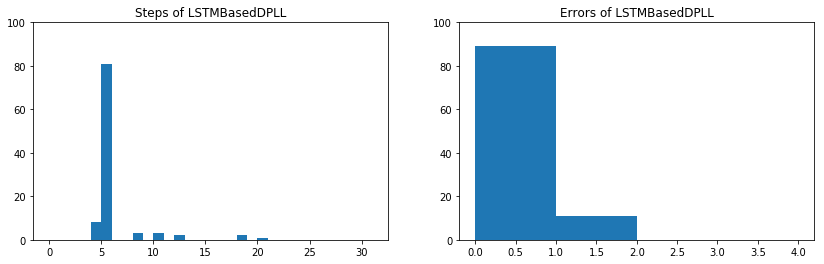

#Sats: 100; avg step: 6.17; stdev step: 2.66; avg error: 0.41; stdev error: 0.65


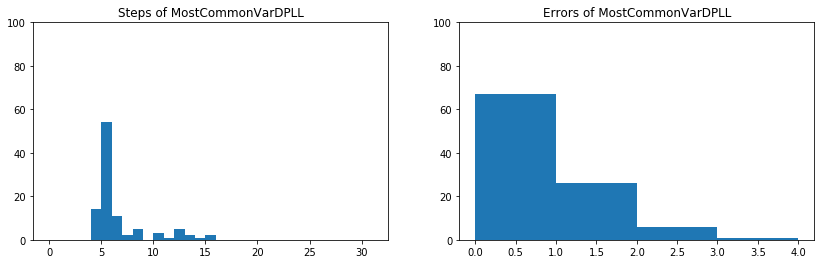

In [16]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 10.36; stdev step: 4.29; avg error: 1.96; stdev error: 1.02


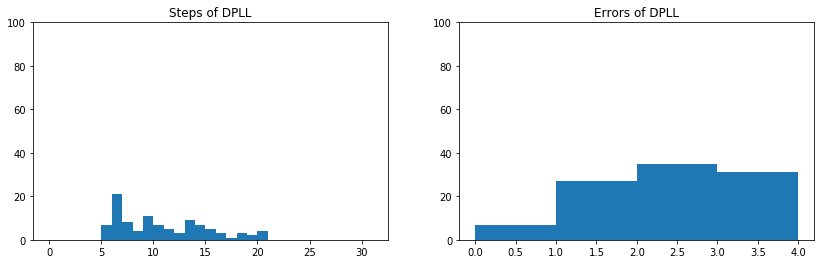

#Sats: 100; avg step: 9.69; stdev step: 3.83; avg error: 1.97; stdev error: 1.02


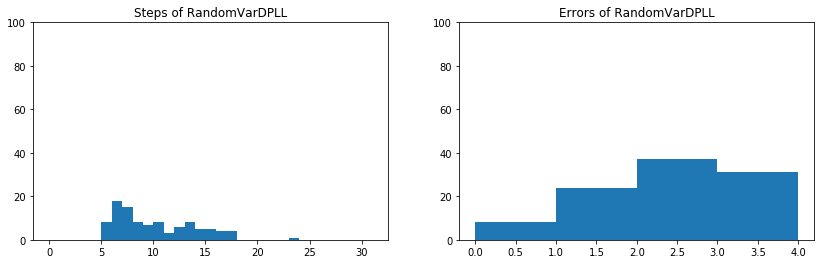

#Sats: 100; avg step: 8.28; stdev step: 3.54; avg error: 1.04; stdev error: 0.87


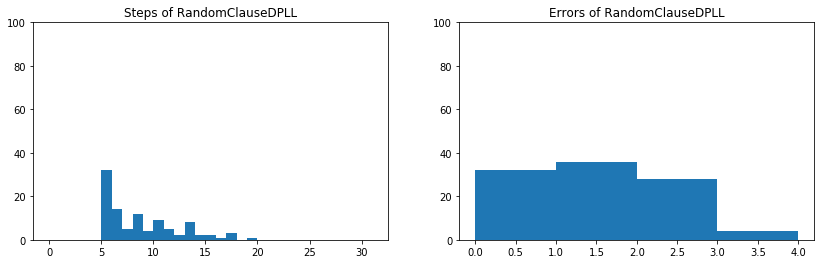

#Sats: 100; avg step: 5.60; stdev step: 1.74; avg error: 0.12; stdev error: 0.32


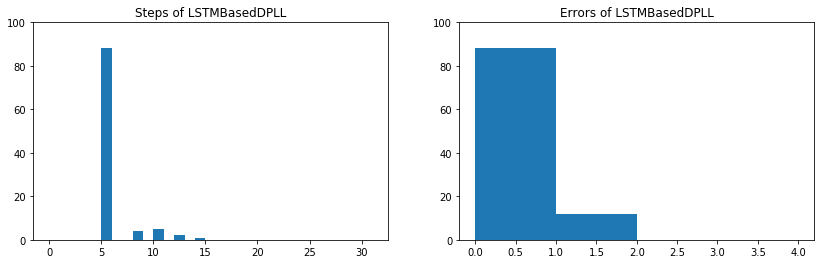

#Sats: 100; avg step: 6.07; stdev step: 2.41; avg error: 0.29; stdev error: 0.50


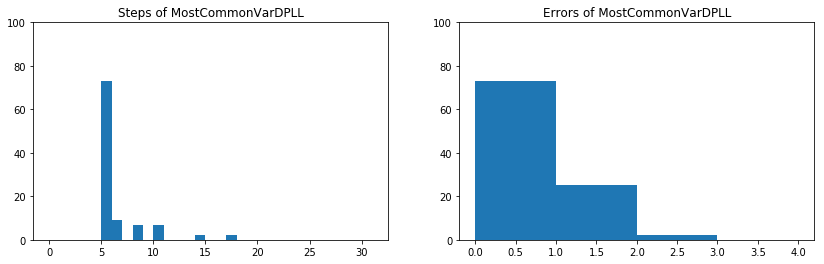

In [17]:
print_all(100, 3, 4, 40)

#Sats: 100; avg step: 14.47; stdev step: 5.93; avg error: 2.14; stdev error: 1.02


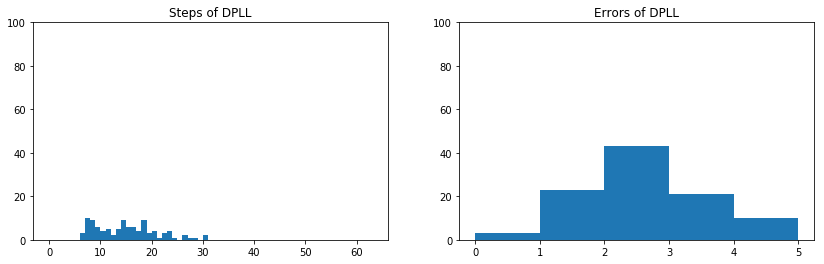

#Sats: 100; avg step: 14.48; stdev step: 6.86; avg error: 2.36; stdev error: 1.11


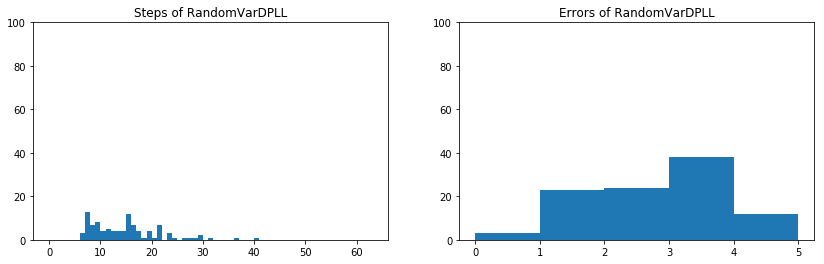

#Sats: 100; avg step: 11.99; stdev step: 6.12; avg error: 1.36; stdev error: 0.96


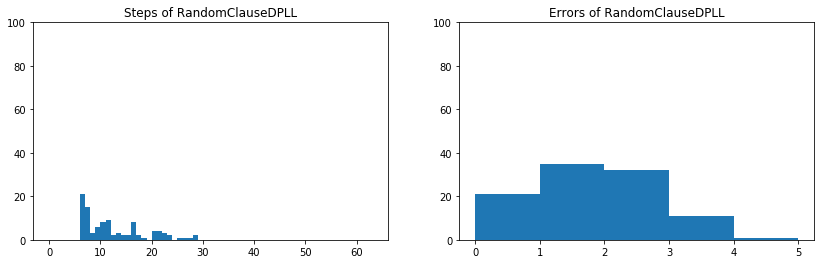

#Sats: 100; avg step: 7.69; stdev step: 4.58; avg error: 0.15; stdev error: 0.36


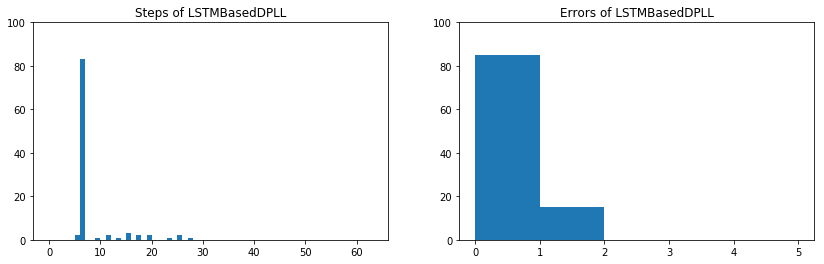

#Sats: 100; avg step: 8.33; stdev step: 3.98; avg error: 0.56; stdev error: 0.68


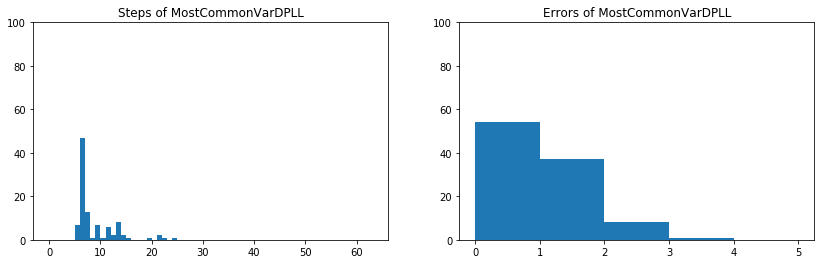

In [18]:
print_all(100, 3, 5, 30)

#Sats: 100; avg step: 13.97; stdev step: 6.19; avg error: 2.35; stdev error: 1.15


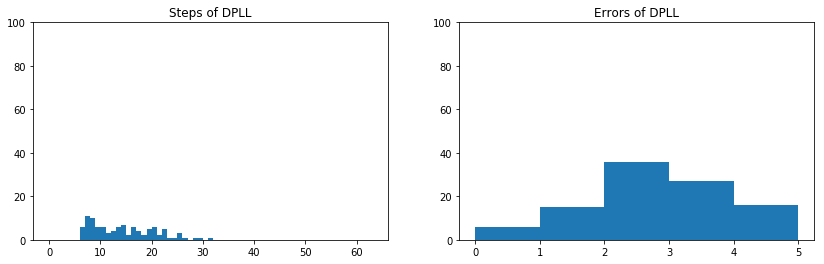

#Sats: 100; avg step: 14.15; stdev step: 5.98; avg error: 2.35; stdev error: 1.02


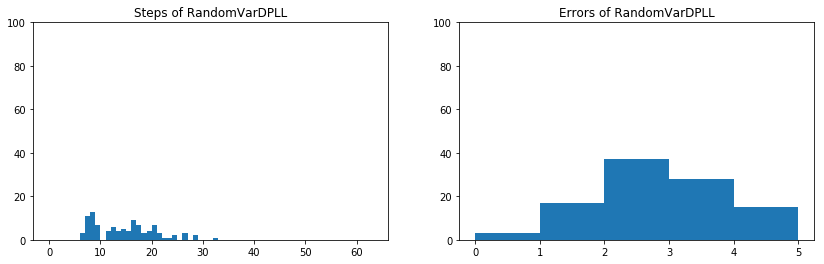

#Sats: 100; avg step: 12.01; stdev step: 5.88; avg error: 1.41; stdev error: 0.91


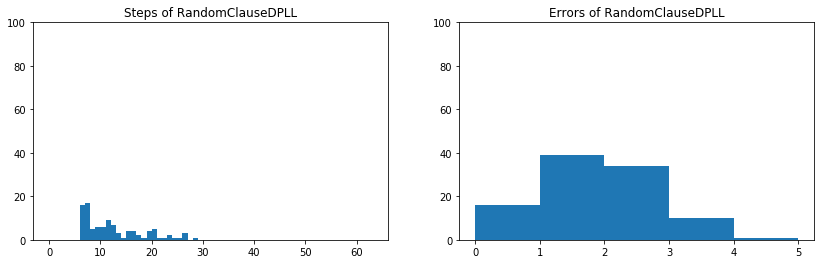

#Sats: 100; avg step: 7.13; stdev step: 3.26; avg error: 0.13; stdev error: 0.34


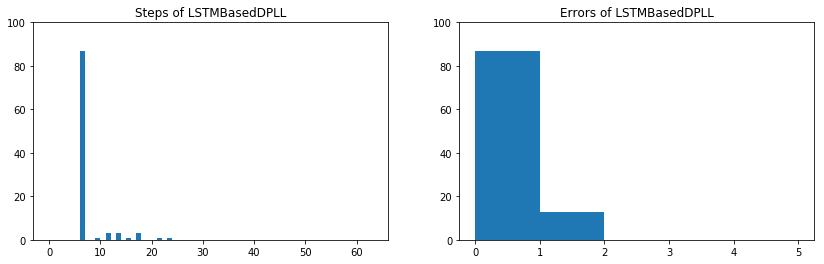

#Sats: 100; avg step: 7.82; stdev step: 2.94; avg error: 0.48; stdev error: 0.61


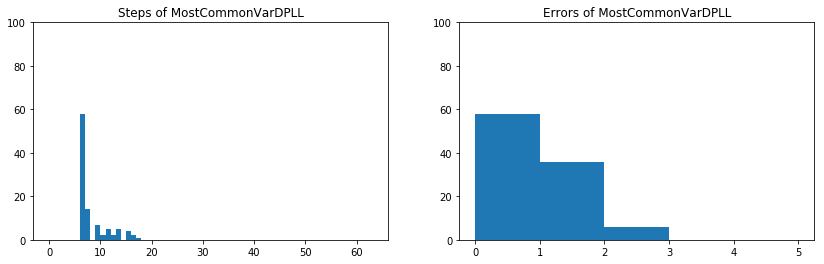

In [19]:
print_all(100, 3, 5, 40)

#Sats: 100; avg step: 20.37; stdev step: 9.16; avg error: 2.86; stdev error: 1.20


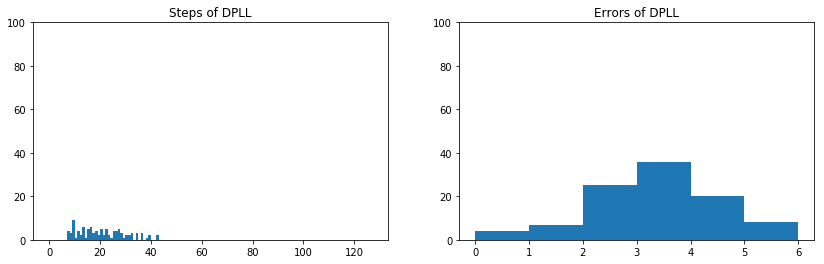

#Sats: 100; avg step: 20.46; stdev step: 11.19; avg error: 2.68; stdev error: 1.19


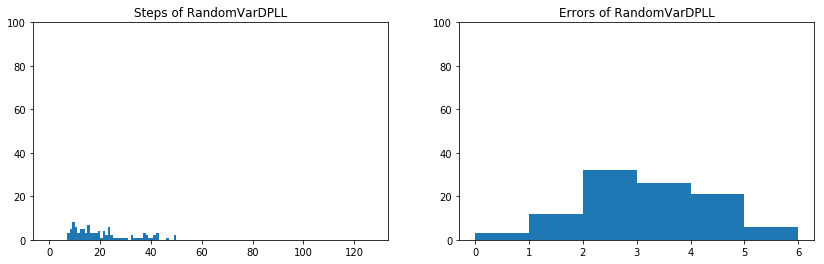

#Sats: 100; avg step: 17.81; stdev step: 10.35; avg error: 1.75; stdev error: 1.17


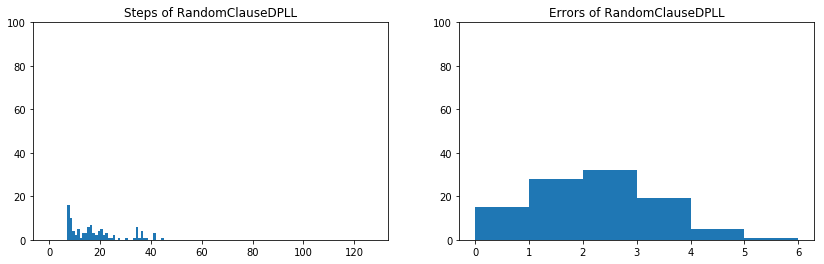

#Sats: 100; avg step: 10.65; stdev step: 8.11; avg error: 0.25; stdev error: 0.46


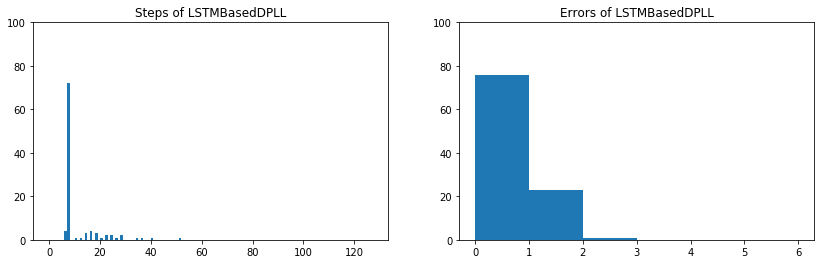

#Sats: 100; avg step: 11.00; stdev step: 6.40; avg error: 0.52; stdev error: 0.56


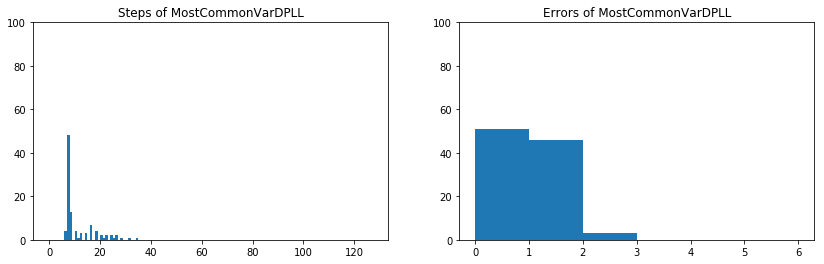

In [20]:
print_all(100, 3, 6, 40)

#Sats: 100; avg step: 18.92; stdev step: 7.83; avg error: 3.12; stdev error: 1.12


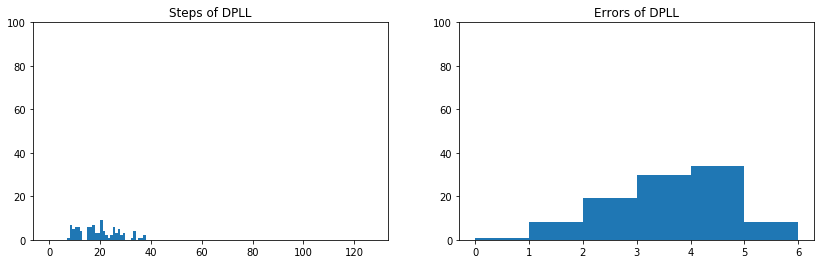

#Sats: 100; avg step: 16.74; stdev step: 7.19; avg error: 2.82; stdev error: 1.26


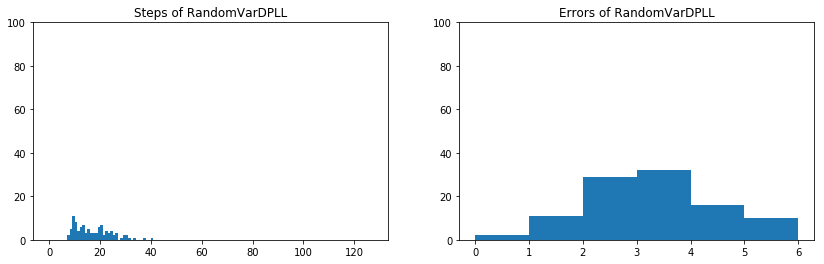

#Sats: 100; avg step: 13.93; stdev step: 6.25; avg error: 1.91; stdev error: 1.18


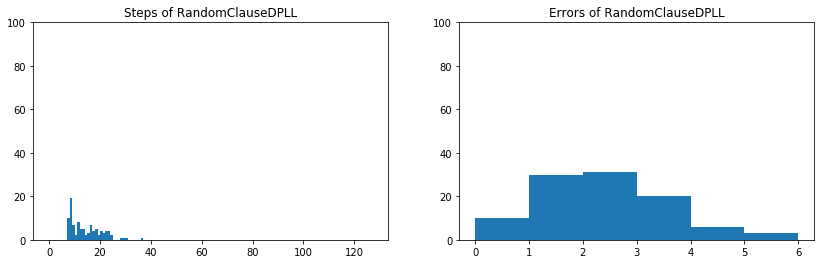

#Sats: 100; avg step: 8.59; stdev step: 4.18; avg error: 0.17; stdev error: 0.40


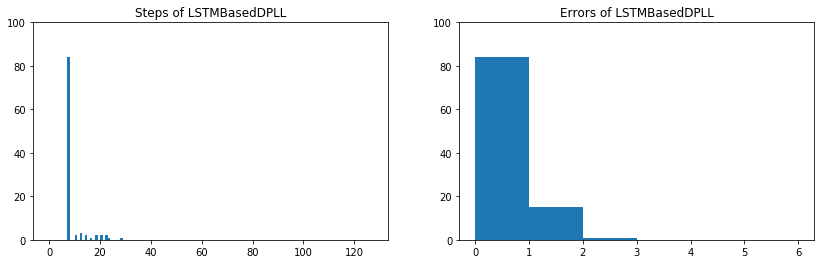

#Sats: 100; avg step: 8.41; stdev step: 2.87; avg error: 0.29; stdev error: 0.45


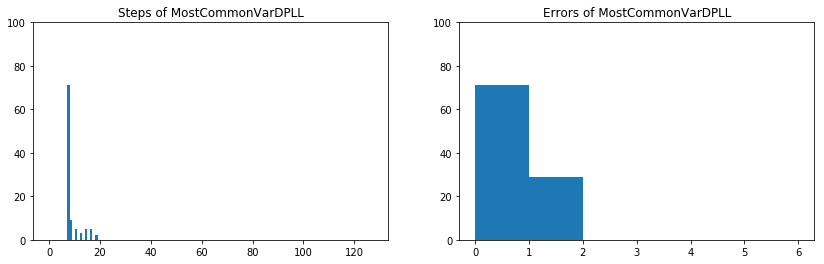

In [21]:
print_all(100, 3, 6, 70)

#Sats: 100; avg step: 22.07; stdev step: 15.80; avg error: 2.30; stdev error: 1.20


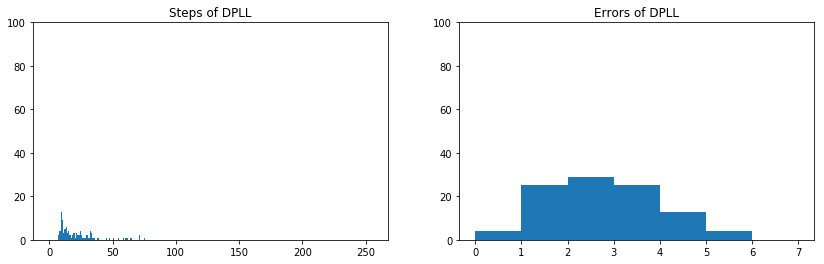

#Sats: 100; avg step: 19.34; stdev step: 13.55; avg error: 2.18; stdev error: 1.22


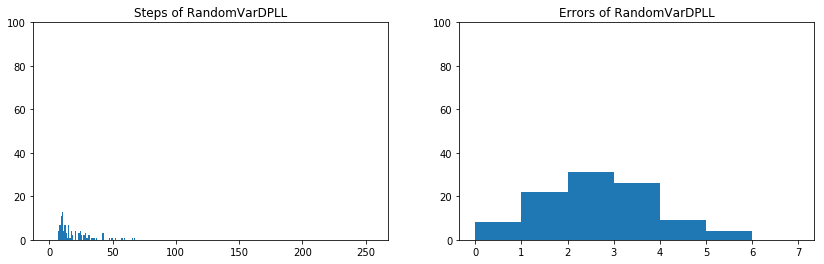

#Sats: 100; avg step: 15.39; stdev step: 11.01; avg error: 1.16; stdev error: 1.01


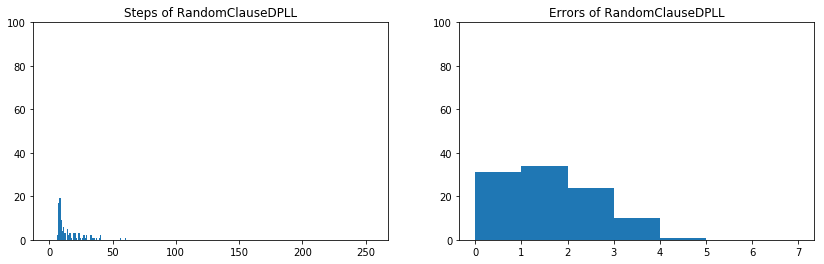

#Sats: 100; avg step: 9.65; stdev step: 7.28; avg error: 0.13; stdev error: 0.36


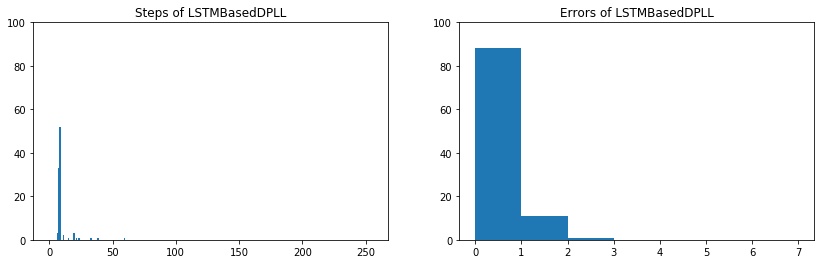

#Sats: 100; avg step: 9.09; stdev step: 5.62; avg error: 0.47; stdev error: 0.71


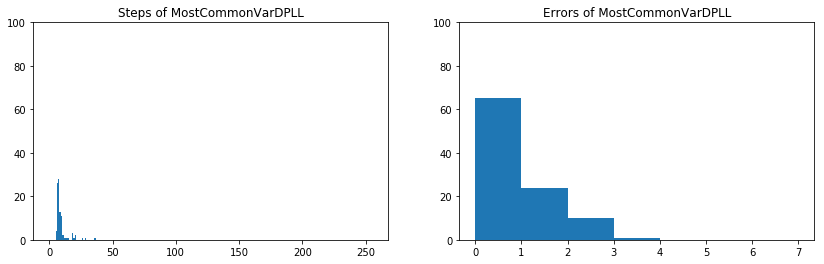

In [22]:
print_all(100, 3, 7, 20)

#Sats: 100; avg step: 24.08; stdev step: 10.91; avg error: 3.42; stdev error: 1.18


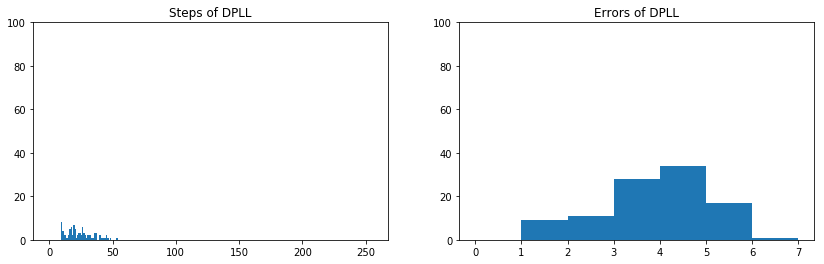

#Sats: 100; avg step: 23.95; stdev step: 12.31; avg error: 3.37; stdev error: 1.29


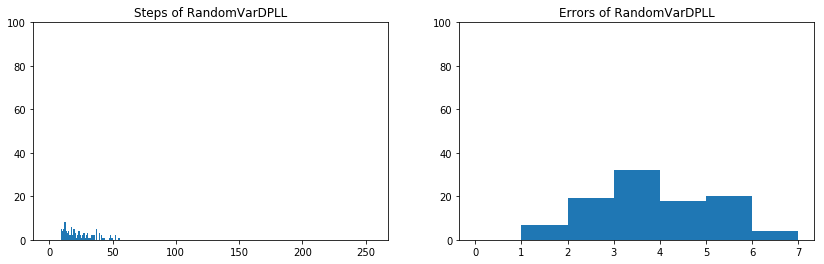

#Sats: 100; avg step: 19.65; stdev step: 8.40; avg error: 2.22; stdev error: 1.20


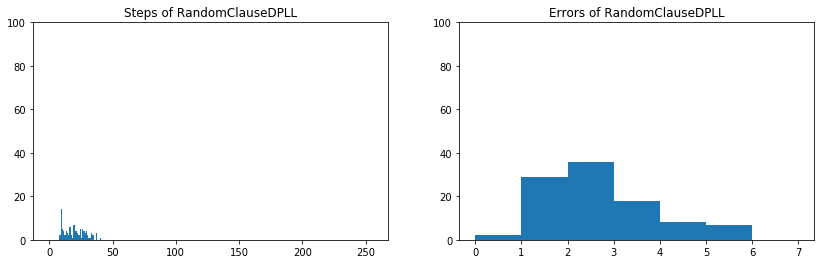

#Sats: 100; avg step: 13.36; stdev step: 9.77; avg error: 0.34; stdev error: 0.53


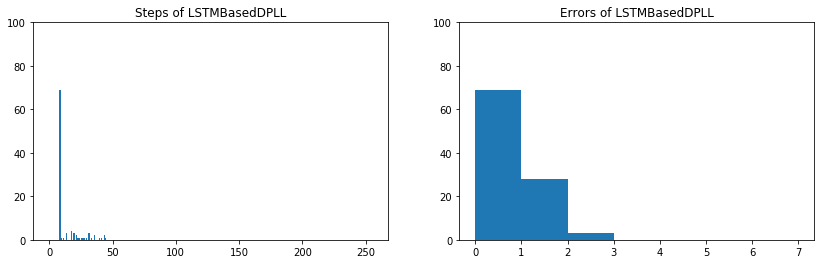

#Sats: 100; avg step: 10.08; stdev step: 4.39; avg error: 0.42; stdev error: 0.55


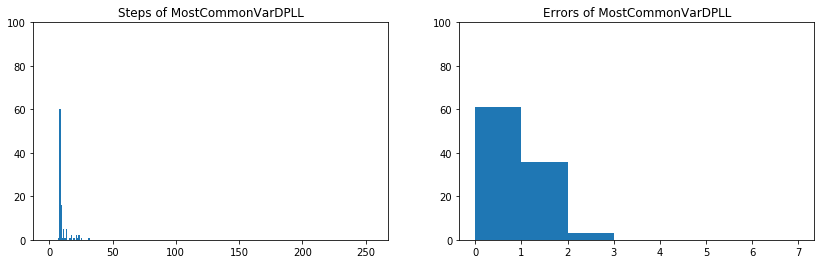

In [23]:
print_all(100, 3, 7, 70)

#Sats: 100; avg step: 40.70; stdev step: 25.72; avg error: 3.49; stdev error: 1.45


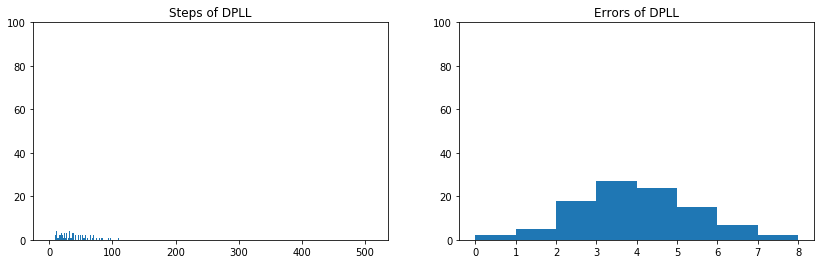

#Sats: 100; avg step: 41.45; stdev step: 21.01; avg error: 3.45; stdev error: 1.27


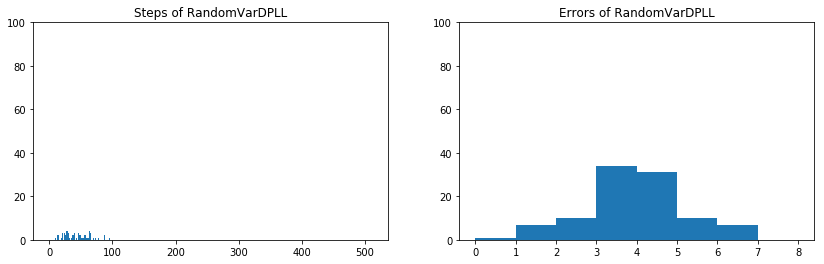

#Sats: 100; avg step: 30.46; stdev step: 21.90; avg error: 2.09; stdev error: 1.39


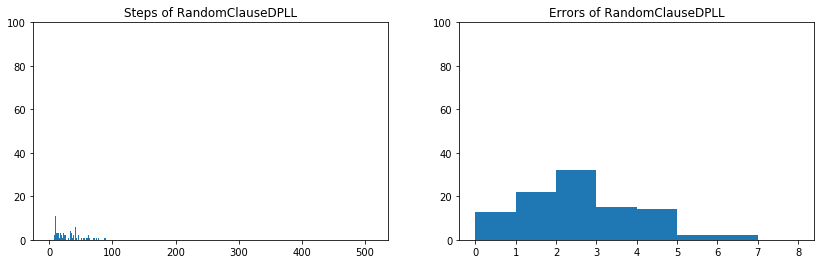

InvalidArgumentError: indices[62,6,2] = 8 is not in [0, 8)
	 [[Node: embedding_lookup = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@embeddings"], validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embeddings/read, Abs)]]

Caused by op 'embedding_lookup', defined at:
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tornado/ioloop.py", line 760, in _run_callback
    ret = callback()
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-dd2c3cc565b2>", line 12, in <module>
    saver = tf.train.import_meta_graph(META_FILE)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1909, in import_meta_graph
    **kwargs)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 737, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 553, in import_graph_def
    op_def=op_def)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[62,6,2] = 8 is not in [0, 8)
	 [[Node: embedding_lookup = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@embeddings"], validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embeddings/read, Abs)]]


In [24]:
print_all(100, 3, 8, 40)

In [ ]:
print_all(100, 3, 8, 50)